In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
#from pandas.tools.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
#import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
import tensorflow as tf

### Combining all blocks

In [7]:
for num in range(0,112):
    df = pd.read_csv("C:/Users/EunJin/Desktop/전력/archive/daily_dataset/daily_dataset/block_"+str(num)+".csv")
    df = df[['day','LCLid','energy_sum']]
    df.reset_index()
    df.to_csv("hc_"+str(num)+".csv")

fout= open("new_energy.csv","a")
# first file:
for line in open("hc_0.csv"):
    fout.write(line)
# now the rest:    
for num in range(0,112):
    f = open("hc_"+str(num)+".csv")
    f.readline() # skip the header
    for line in f:
         fout.write(line)
    f.close()
fout.close()

In [8]:
df1 = pd.read_csv('new_energy.csv')
len(df1)

3536007

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3536007 entries, 0 to 3536006
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   day         object 
 2   LCLid       object 
 3   energy_sum  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 107.9+ MB


In [10]:
df1.head()

,Unnamed: 0,day,LCLid,energy_sum
0,0,2012-10-12,MAC000002,7.098
1,1,2012-10-13,MAC000002,11.087
2,2,2012-10-14,MAC000002,13.223
3,3,2012-10-15,MAC000002,10.257
4,4,2012-10-16,MAC000002,9.769


In [11]:
df1.tail(10)

,Unnamed: 0,day,LCLid,energy_sum
3535997,9898,2014-02-19,MAC004828,1.469
3535998,9899,2014-02-20,MAC004828,0.677
3535999,9900,2014-02-21,MAC004828,0.653
3536000,9901,2014-02-22,MAC004828,0.754
3536001,9902,2014-02-23,MAC004828,0.683
3536002,9903,2014-02-24,MAC004828,2.587
3536003,9904,2014-02-25,MAC004828,0.720
3536004,9905,2014-02-26,MAC004828,1.051
3536005,9906,2014-02-27,MAC004828,0.736
3536006,9907,2014-02-28,MAC004828,0.000


In [12]:
df1['day'].unique()

array(['2012-10-12', '2012-10-13', '2012-10-14', '2012-10-15',
       '2012-10-16', '2012-10-17', '2012-10-18', '2012-10-19',
       '2012-10-20', '2012-10-21', '2012-10-22', '2012-10-23',
       '2012-10-24', '2012-10-25', '2012-10-26', '2012-10-27',
       '2012-10-28', '2012-10-29', '2012-10-30', '2012-10-31',
       '2012-11-01', '2012-11-02', '2012-11-03', '2012-11-04',
       '2012-11-05', '2012-11-06', '2012-11-07', '2012-11-08',
       '2012-11-09', '2012-11-10', '2012-11-11', '2012-11-12',
       '2012-11-13', '2012-11-14', '2012-11-15', '2012-11-16',
       '2012-11-17', '2012-11-18', '2012-11-19', '2012-11-20',
       '2012-11-21', '2012-11-22', '2012-11-23', '2012-11-24',
       '2012-11-25', '2012-11-26', '2012-11-27', '2012-11-28',
       '2012-11-29', '2012-11-30', '2012-12-01', '2012-12-02',
       '2012-12-03', '2012-12-04', '2012-12-05', '2012-12-06',
       '2012-12-07', '2012-12-08', '2012-12-09', '2012-12-10',
       '2012-12-11', '2012-12-12', '2012-12-13', '2012-

In [13]:
df1[df1['day'].str.contains('day')].index

Int64Index([], dtype='int64')

In [14]:
df1.iloc[3536007:3536008]

,Unnamed: 0,day,LCLid,energy_sum


In [15]:
len(df1)

3536007

In [16]:
df1 = df1[~df1['day'].str.contains('day')]
len(df1)

3536007

In [17]:
df1[df1['day'].str.contains('day')].index

Int64Index([], dtype='int64')

In [18]:
df1['energy_sum'] = df1['energy_sum'].astype(float)

In [19]:
df1['day'] = pd.to_datetime(df1['day'], format='%Y-%m-%d').dt.date

### House Count
데이터셋에 런던에 스마트미터를 가입하는 가구수가 증가하므로, 자칫 데이터 해석을 잘못할 수 있음, day로 groupby해서 스마트미터에 가입하는 house 수를 count하기 위한 과정

In the dataset we see that the number of households for which energy data was collected across different days are different. This is probably due to the gradually increasing adoption of smart meters in London. This could lead to false interpretation that the energy for a particular day might be high when it could be that the data was only collected for more number of houses. We will look at the house count for each day.

In [20]:
housecount = df1.groupby('day')[['LCLid']].nunique()
housecount = housecount.reset_index()

housecount.tail()

,day,LCLid
824,2014-02-24,4994
825,2014-02-25,4995
826,2014-02-26,4993
827,2014-02-27,4990
828,2014-02-28,4987


In [21]:
housecount.head()

,day,LCLid
0,2011-11-23,13
1,2011-11-24,25
2,2011-11-25,32
3,2011-11-26,41
4,2011-11-27,41


In [22]:
housecount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     829 non-null    object
 1   LCLid   829 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.1+ KB


<AxesSubplot:>

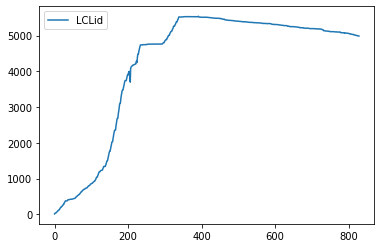

In [23]:
housecount.plot()

## Normalization across households

The data collection across households are inconsistent- therefore we will be using energy per household as the target to predict rather than energy alone. This is an optional step as we can also predict for energy sum as whole for each household. However there are quite a lot of unique households for which we have to repeat the exercise and our ultimate goal is to predict overall consumption forecast and not at household level.
This also means that since household level is removed, we are not looking into the ACORN details which is available at household level

단위를 '가구 당 에너지'로 맞추겠음.

In [24]:
energy = df1.groupby('day')[['energy_sum']].sum()
energy.tail()

,energy_sum
day,
2014-02-24,52867.660004
2014-02-25,52330.109999
2014-02-26,51804.199995
2014-02-27,52580.878999
2014-02-28,1056.076000


In [25]:
energy = energy.reset_index()
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   day         829 non-null    object 
 1   energy_sum  829 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.1+ KB


In [26]:
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index(drop=True)

In [27]:
energy.head()

,day,energy_sum,LCLid
0,2011-11-23,90.385000,13
1,2011-11-24,213.412000,25
2,2011-11-25,303.993000,32
3,2011-11-26,420.976000,41
4,2011-11-27,444.883001,41


In [28]:
energy.tail()

,day,energy_sum,LCLid
824,2014-02-24,52867.660004,4994
825,2014-02-25,52330.109999,4995
826,2014-02-26,51804.199995,4993
827,2014-02-27,52580.878999,4990
828,2014-02-28,1056.076000,4987


In [29]:
energy.count()

day           829
energy_sum    829
LCLid         829
dtype: int64

In [30]:
energy['avg_energy'] = energy['energy_sum']/energy['LCLid']
print("Starting Point of Data at Day Level", min(energy.day))
print("Ending Point of Data at Day Level", max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [31]:
energy.describe()

,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,43535.325676,4234.539204,10.491862
std,20550.594031,1789.994799,1.902513
min,90.385000,13.000000,0.211766
25%,34665.436003,4084.000000,8.676955
50%,46641.160997,5138.000000,10.516983
75%,59755.616996,5369.000000,12.000690
max,84156.135002,5541.000000,15.964434


In [32]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   day         829 non-null    object 
 1   energy_sum  829 non-null    float64
 2   LCLid       829 non-null    int64  
 3   avg_energy  829 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 26.0+ KB


## Weather Information

darksky api에서 주어진 일별 날씨 데이터를 활용한다!

In [33]:
weather = pd.read_csv("C:/Users/EunJin/Desktop/전력/archive/weather_daily_darksky.csv")
weather.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,10.87,rain,3.30,0.95,2011-11-11 19:00:00,10.87,11.96,1.0,2011-11-11 00:00:00,2011-11-11 16:19:21,10.87,8.85,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,5.62,rain,12.09,0.88,2011-12-11 19:00:00,-0.64,5.72,1.0,2011-12-11 00:00:00,2011-12-11 15:52:53,3.09,2.48,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,10.33,rain,13.39,0.74,2011-12-27 14:00:00,5.52,10.33,0.0,2011-12-27 00:00:00,2011-12-27 15:57:56,8.03,8.03,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,5.33,rain,11.89,0.87,2011-12-02 12:00:00,3.26,5.33,1.0,2011-12-02 00:00:00,2011-12-02 15:56:17,6.33,2.56,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,5.02,rain,13.16,0.80,2011-12-24 15:00:00,4.37,5.32,1.0,2011-12-24 00:00:00,2011-12-24 15:55:55,7.45,3.17,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


In [34]:
weather.columns

Index(['temperatureMax', 'temperatureMaxTime', 'windBearing', 'icon',
       'dewPoint', 'temperatureMinTime', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureMinTime', 'apparentTemperatureHigh', 'precipType',
       'visibility', 'humidity', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'time',
       'sunsetTime', 'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'sunriseTime', 'temperatureHighTime', 'uvIndexTime', 'summary',
       'temperatureLowTime', 'apparentTemperatureMin',
       'apparentTemperatureMaxTime', 'apparentTemperatureLowTime',
       'moonPhase'],
      dtype='object')

In [35]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   temperatureMax               882 non-null    float64
 1   temperatureMaxTime           882 non-null    object 
 2   windBearing                  882 non-null    int64  
 3   icon                         882 non-null    object 
 4   dewPoint                     882 non-null    float64
 5   temperatureMinTime           882 non-null    object 
 6   cloudCover                   881 non-null    float64
 7   windSpeed                    882 non-null    float64
 8   pressure                     882 non-null    float64
 9   apparentTemperatureMinTime   882 non-null    object 
 10  apparentTemperatureHigh      882 non-null    float64
 11  precipType                   882 non-null    object 
 12  visibility                   882 non-null    float64
 13  humidity            

In [36]:
weather['time'].head()

0    2011-11-11 00:00:00
1    2011-12-11 00:00:00
2    2011-12-27 00:00:00
3    2011-12-02 00:00:00
4    2011-12-24 00:00:00
Name: time, dtype: object

In [37]:
weather['day'] = pd.to_datetime(weather['time'])
weather['day'] = pd.to_datetime(weather['day'], format='%Y-%m-%d %H:%M:%S').dt.date
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]

In [38]:
weather = weather.dropna()

In [39]:
weather_energy = energy.merge(weather, on='day')
weather_energy.head()

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385000,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,10.36,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412000,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,12.93,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97
2,2011-11-25,303.993000,32,9.499781,13.03,243,7.24,0.48,5.02,1024.47,12.27,12.38,0.79,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01
3,2011-11-26,420.976000,41,10.267707,12.96,237,6.96,0.44,5.75,1025.80,12.96,13.07,0.81,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05
4,2011-11-27,444.883001,41,10.850805,13.54,256,5.76,0.42,5.48,1021.11,13.54,13.08,0.72,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08


In [40]:
weather_energy.tail()

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
823,2014-02-24,52867.660004,4994,10.586235,14.23,183,6.03,0.50,5.02,1005.19,14.23,13.00,0.74,4.78,14.23,1.0,8.25,7.99,14.23,5.52,0.82
824,2014-02-25,52330.109999,4995,10.476498,11.43,202,5.06,0.62,5.69,1000.65,10.31,12.09,0.78,1.67,11.43,1.0,4.17,6.79,10.31,3.89,0.86
825,2014-02-26,51804.199995,4993,10.375366,11.29,227,2.74,0.26,3.82,1012.73,11.29,13.00,0.73,3.03,11.29,2.0,6.01,4.17,11.29,1.67,0.90
826,2014-02-27,52580.878999,4990,10.537250,10.31,224,3.08,0.32,4.14,1007.02,10.31,12.04,0.74,0.82,10.31,2.0,3.43,3.93,10.31,1.41,0.93
827,2014-02-28,1056.076000,4987,0.211766,7.35,61,3.11,0.67,2.24,998.92,4.51,10.80,0.86,0.76,4.51,1.0,3.05,3.43,7.35,0.82,0.97


In [41]:
weather_energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 827
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   day                      828 non-null    object 
 1   energy_sum               828 non-null    float64
 2   LCLid                    828 non-null    int64  
 3   avg_energy               828 non-null    float64
 4   temperatureMax           828 non-null    float64
 5   windBearing              828 non-null    int64  
 6   dewPoint                 828 non-null    float64
 7   cloudCover               828 non-null    float64
 8   windSpeed                828 non-null    float64
 9   pressure                 828 non-null    float64
 10  apparentTemperatureHigh  828 non-null    float64
 11  visibility               828 non-null    float64
 12  humidity                 828 non-null    float64
 13  apparentTemperatureLow   828 non-null    float64
 14  apparentTemperatureMax   8

### 1. Temperature

We can see that energy and temperature have an inverse relationship-we can see the peaks in one appearing with troughs in the other. This confirms the business intuition that during low temperature, it is likely that the energy consumption through heaters etc. increases.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


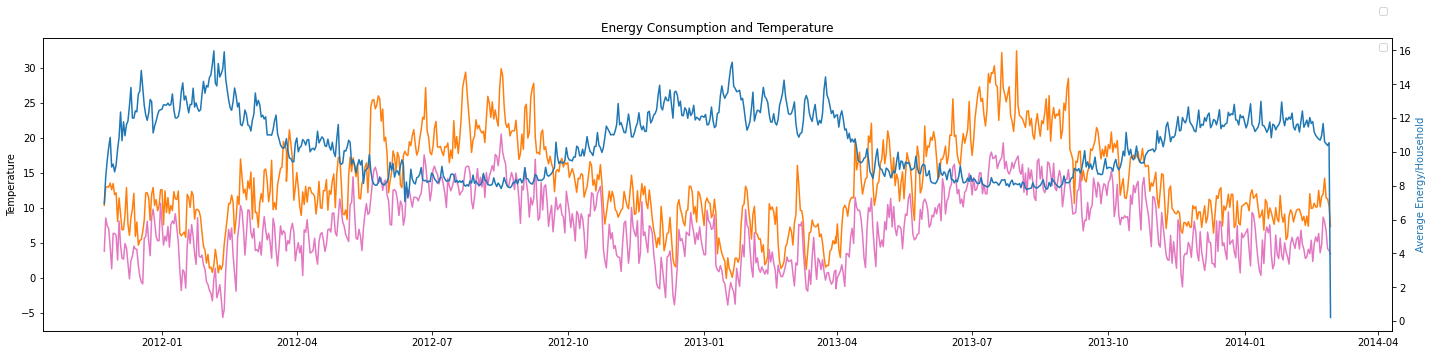

In [42]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color= 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day, weather_energy.avg_energy, color='tab:blue')
ax2.set_ylabel('Average Energy/Household', color='tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

-> 기온과 가구당 에너지 평균 소비량은 정반대의 트렌드를 보이고 있다.

### 2. Humidity
Humidity and the average consumption of energy seems to have the same trend.

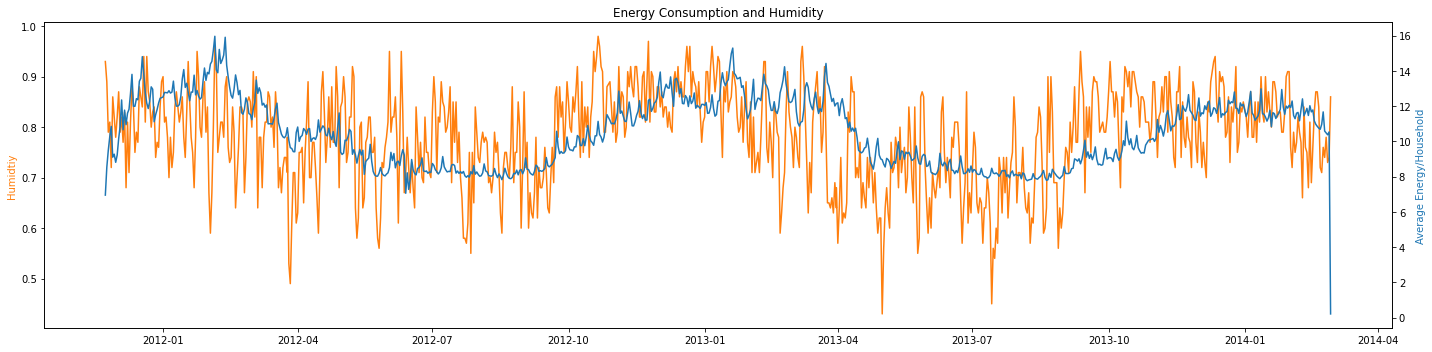

In [43]:
fig, ax1 = plt.subplots(figsize = (20, 5))
ax1.plot(weather_energy.day, weather_energy.humidity, color='tab:orange')
ax1.set_ylabel('Humidtiy', color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day, weather_energy.avg_energy, color ='tab:blue')
ax2.set_ylabel('Average Energy/Household', color='tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

-> 습도와 가구당 에너지 평균 사용량은 비슷한 트렌드를 보인다.

### 3. Cloud Cover
The colud cover value seems to be following the same pattern as the energy consumption.

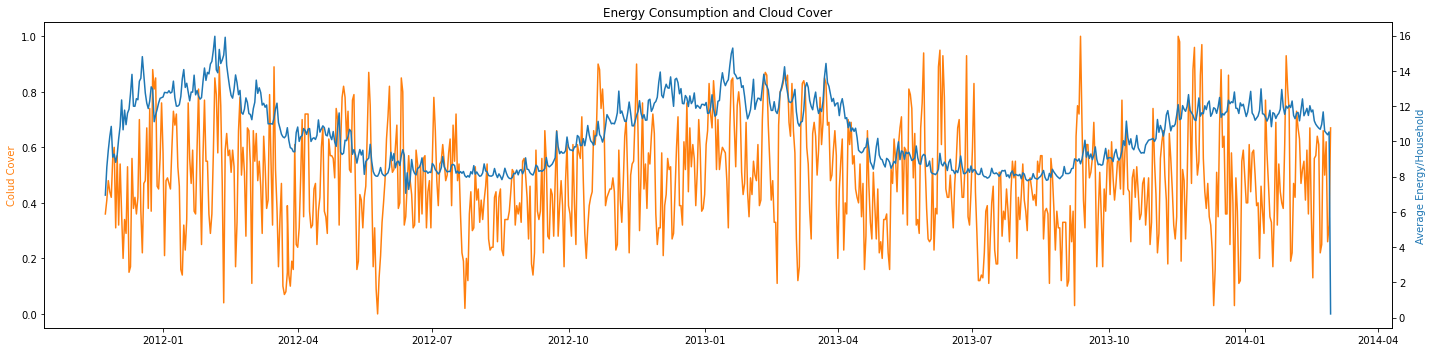

In [44]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color='tab:orange')
ax1.set_ylabel('Colud Cover', color='tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day, weather_energy.avg_energy, color='tab:blue')
ax2.set_ylabel('Average Energy/Household', color='tab:blue')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

-> 구름양과 가구당 에너지 평균 사용량도 비슷한 트렌드를 보이는 듯하다.

### 4. Visibility(가시성, 시정, 대기의 혼탁도를 나타내는 척도)
The visibility factor does not seem to affect energy consumption at all- since visibility is most likely an outdoors factor, it is unlikely that it's increase or decrease affects energy consumption within a household.

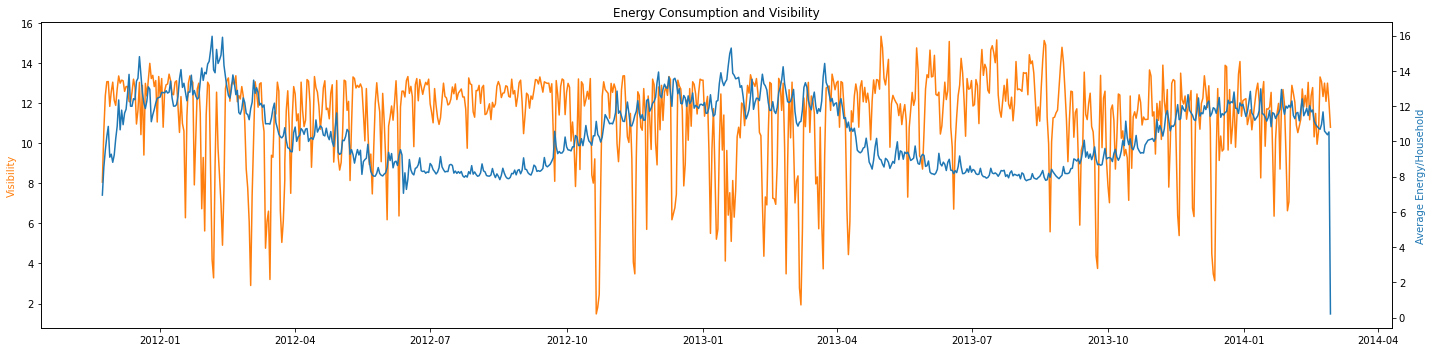

In [45]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.visibility, color = 'tab:orange')
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

-> 가시성과 가구당 에너지 평균 사용량과는 큰 연관성은 없어보인다. 이는 실외 요인이므로 에너지 평균 사용량(에어컨, 히터 등)에 영향을 주지 않는 것으로 예상된다.

### 5. Wind Speed
Like visibility, wind speed seems to be an outdoors factor which does not affect in the energy consumption as such.

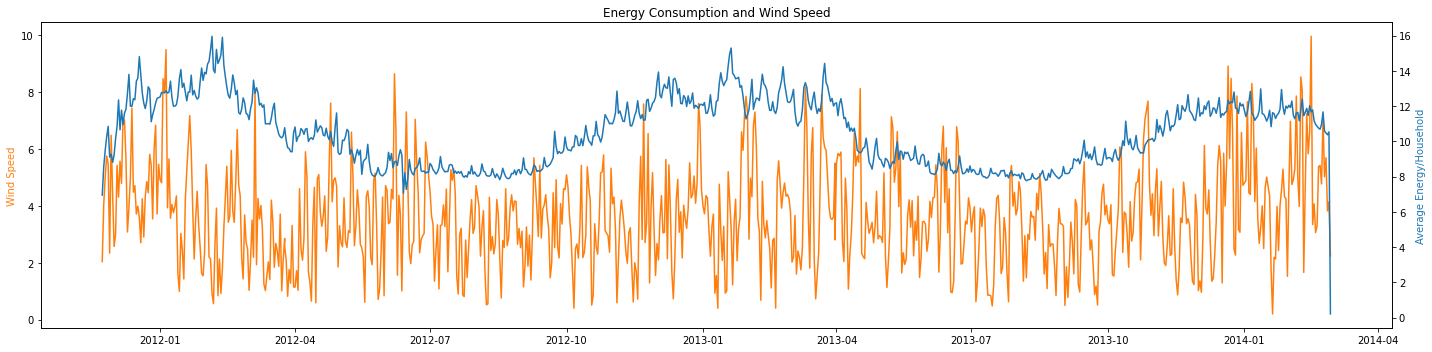

In [46]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:orange')
ax1.set_ylabel('Wind Speed',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

-> 풍력도 실외변수여서 큰 영향을 미치지 않는 것 같다.

### 6. UV Index
The UV index has an inverse relationship with energy consumption-why?

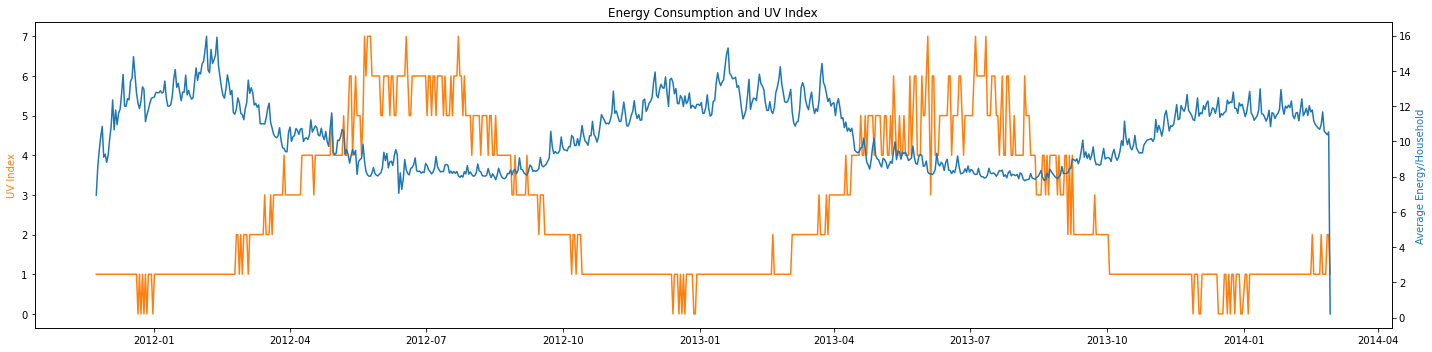

In [47]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:orange')
ax1.set_ylabel('UV Index',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

-> 우선 UV Index는 계절성을 보인다(여름에 높아지고, 겨울에 낮아짐)
겨울 히터보다 여름 에어컨을 더 많이 사용해서 이런 패턴을 보이는 것은 아닌지 추측...

### 7. dewPoint(이슬점)
Dew Point- is a function of humidity and temperature therefore it displays similar relation to energy consumption.

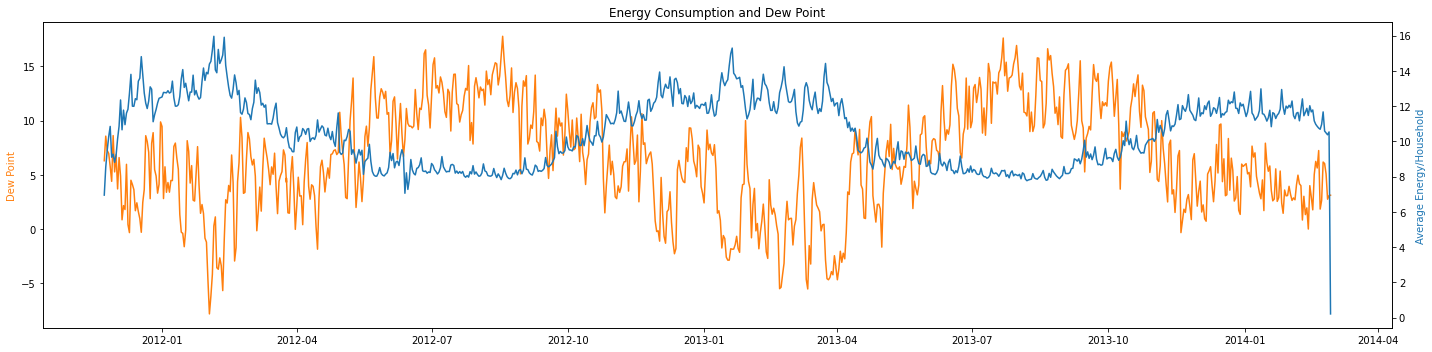

In [48]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:orange')
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

-> 이슬점의 계절성 때문에 위와 비슷한 패턴을 보이는 듯하다.

* 수증기로 포화되지 않은 공기를 냉각시키면 100%의 상대습도가 되어 포화상태에 도달하는데, 이때의 기온을 이슬점이라 한다. 공기가 이슬점 온도 이하로 냉각되면 여분의 수증기는 응결하여 물방울이 된다.

## Correlation between Weather Variables and Energy Consumption
* Energy has high positive correlation with humidity and high negative correlation with temperature.
* Dew Point, UV Index display multicollinearity with Temperature, hence discarded
* Cloud Cover and Visibility display multicollinearity with Humidity, hence discarded
* Pressure and Moon Phase have minimal correlation with Energy, hence discarded
* Wind Speed has low correlation with energy but does not show multicollinearity

In [49]:
cor_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix

,avg_energy,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,moonPhase
avg_energy,1.000000,-0.846965,-0.755901,0.241779,0.149624,-0.028851,-0.246404,0.361237,-0.733171,-0.031716
temperatureMax,-0.846965,1.000000,0.865038,-0.333409,-0.153602,0.118933,0.259108,-0.404899,0.696497,0.003636
dewPoint,-0.755901,0.865038,1.000000,-0.025207,-0.092212,-0.028121,0.042633,0.055514,0.486692,-0.008239
cloudCover,0.241779,-0.333409,-0.025207,1.000000,0.170235,-0.101079,-0.330177,0.480056,-0.248695,-0.062126
windSpeed,0.149624,-0.153602,-0.092212,0.170235,1.000000,-0.344354,0.281088,-0.042391,-0.152634,-0.023273
pressure,-0.028851,0.118933,-0.028121,-0.101079,-0.344354,1.000000,-0.012508,-0.250941,0.100774,0.038462
visibility,-0.246404,0.259108,0.042633,-0.330177,0.281088,-0.012508,1.000000,-0.578130,0.240485,0.062813
humidity,0.361237,-0.404899,0.055514,0.480056,-0.042391,-0.250941,-0.578130,1.000000,-0.533919,-0.013997
uvIndex,-0.733171,0.696497,0.486692,-0.248695,-0.152634,0.100774,0.240485,-0.533919,1.000000,0.012833
moonPhase,-0.031716,0.003636,-0.008239,-0.062126,-0.023273,0.038462,0.062813,-0.013997,0.012833,1.000000


## Creating Weather Clusters
The weather information has a lot of variables- which might not all be useful. We will attempt to create weather clusters to see if we can define a weather of the day based on the granular weather data like temperature, precipitation etc.

-> 추후 PCA로 차원축소해도 될 듯

-> 아니면 변수 구간화로 만들고, 주요변수만 사용해서 모델링하기

In [50]:
#scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax','humidity','windSpeed']])

[-81.38340158733622, -52.95736322765413, -38.97797708936125, -33.23147586972943, -29.05069966396142, -25.59966698643179, -23.137349757053553, -20.98545740378816, -19.521290729761432, -18.174186257660335, -17.120026479811248, -16.171539959444424, -15.265869049531478, -14.475086622393249, -13.867334859242515, -13.179509601464272, -12.665882505013759, -12.319539000558589, -11.753526400528758]


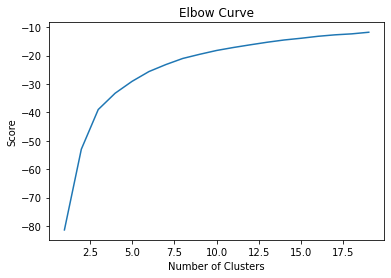

In [51]:
#optimum K
Nc = range(1,20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
#print(kmeans)

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
print(score)

plt.plot(Nc, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [52]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

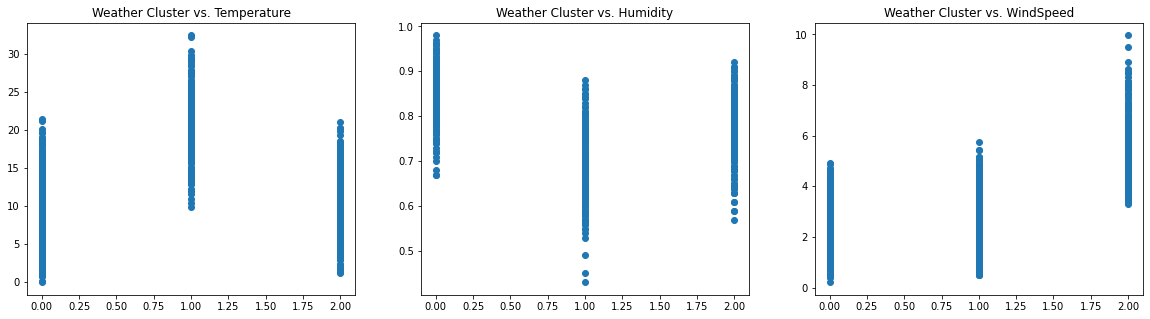

In [53]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_
# Cluster Relationships with weather variables
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(weather_energy.weather_cluster,weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(weather_energy.weather_cluster,weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(weather_energy.weather_cluster,weather_energy.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()
# put this in a loop

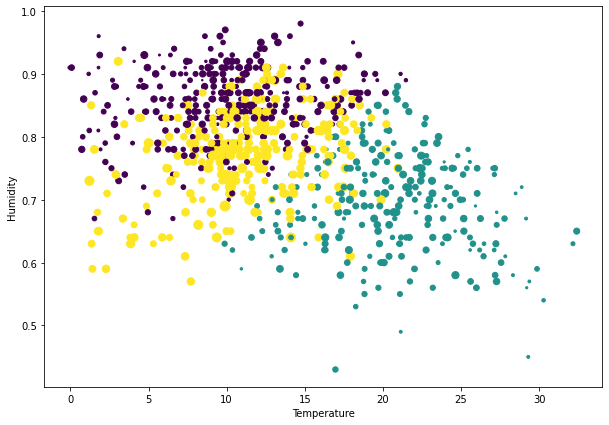

In [54]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.temperatureMax, weather_energy.humidity, s=weather_energy.windSpeed*10, c=weather_energy.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

## UK Bank Holidays (공휴일 여부)

In [55]:
holiday = pd.read_csv("C:/Users/EunJin/Desktop/전력/archive/uk_bank_holidays.csv")
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'], format='%Y-%m-%d').dt.date
holiday.head()

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


In [56]:
holiday.tail()

,Bank holidays,Type
20,2014-05-26,Spring bank holiday
21,2014-05-05,Early May bank holiday
22,2014-04-21,Easter Monday
23,2014-04-18,Good Friday
24,2014-01-01,New Year?s Day


### Creating a holiday indicator on weather data

In [57]:
weather_energy = weather_energy.merge(holiday, left_on='day', right_on='Bank holidays', how='left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(), 0,1)

In [58]:
weather_energy.head()

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,weather_cluster,Bank holidays,Type,holiday_ind
0,2011-11-23,90.385000,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,10.36,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,0,NaN,NaN,0
1,2011-11-24,213.412000,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,12.93,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97,0,NaN,NaN,0
2,2011-11-25,303.993000,32,9.499781,13.03,243,7.24,0.48,5.02,1024.47,12.27,12.38,0.79,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01,2,NaN,NaN,0
3,2011-11-26,420.976000,41,10.267707,12.96,237,6.96,0.44,5.75,1025.80,12.96,13.07,0.81,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05,2,NaN,NaN,0
4,2011-11-27,444.883001,41,10.850805,13.54,256,5.76,0.42,5.48,1021.11,13.54,13.08,0.72,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08,2,NaN,NaN,0


In [59]:
weather_energy[weather_energy['holiday_ind']==1].head()

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,weather_cluster,Bank holidays,Type,holiday_ind
70,2012-02-01,8160.777998,590,13.831827,3.36,53,-4.69,0.36,5.45,1032.32,-1.86,11.41,0.67,-6.49,-1.86,1.0,-1.66,-0.92,3.36,-5.98,0.29,2,2012-02-01,New Year?s Day (substitute day),1
136,2012-04-06,14256.724006,1342,10.623490,10.48,2,4.36,0.72,2.09,1012.32,10.48,11.64,0.75,4.57,10.48,3.0,6.52,6.86,10.48,6.42,0.53,0,2012-04-06,Spring bank holiday (substitute day),1
166,2012-05-06,25184.476998,2358,10.680440,14.48,160,6.55,0.52,2.54,1014.29,14.48,11.64,0.82,10.43,14.48,4.0,10.43,5.20,14.48,4.48,0.55,0,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday),1
195,2012-06-04,33344.720000,3741,8.913317,15.00,160,8.14,0.51,3.42,1014.65,15.00,11.30,0.82,11.54,15.00,6.0,11.54,7.54,15.00,7.54,0.54,0,2012-06-04,Good Friday,1
226,2012-07-05,35440.096999,4348,8.150896,18.70,193,13.22,0.39,2.46,1007.45,18.70,11.89,0.82,13.42,18.70,5.0,13.42,14.78,18.70,14.78,0.60,1,2012-07-05,Early May bank holiday,1


## ARIMAX

In [60]:
weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index(['day'],inplace=True)

#### Subset fot required columns and 70:30 train:test split

In [61]:
model_data = weather_energy[['avg_energy','weather_cluster','holiday_ind']]

train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

In [62]:
print(len(train), len(test))

798 29


<AxesSubplot:xlabel='day'>

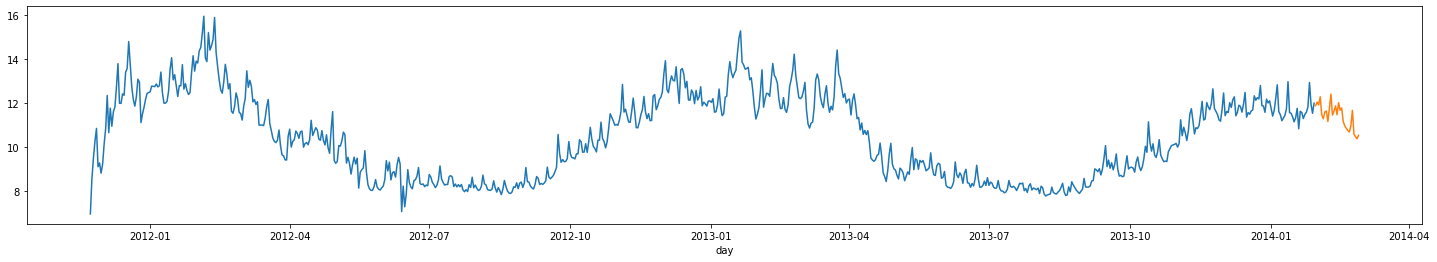

In [63]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))

In [64]:
test.head(5)

,avg_energy,weather_cluster,holiday_ind
day,,,
2014-01-30,11.886982,0,0
2014-01-31,12.051321,0,0
2014-02-01,11.921217,2,0
2014-02-02,12.291726,2,0
2014-02-03,11.471760,2,0


### ACF PACF

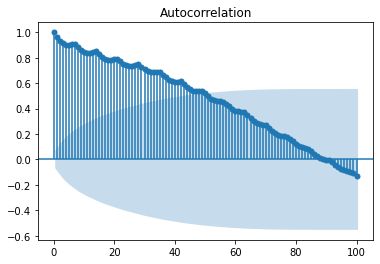

In [65]:
plot_acf(train.avg_energy, lags=100)
plt.show()

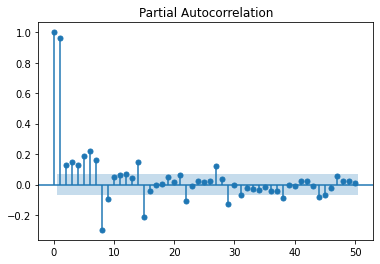

In [66]:
plot_pacf(train.avg_energy, lags=50)
plt.show()

Autocorrelation plot shows gradual decay while Partial AutoCorrelation shows that there is a sharp drop after 1st lag. This means that most of the higher-order autocorrelations are effectively explained by the k = 1 lag. Therefore, the series displays AR 'signature'

### Dickey Fuller's Test

p is greater than 0.05 therefore the data is not stationary. After differencing, p < 0.05.

In [68]:
t = sm.tsa.adfuller(train.avg_energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic', 'p-value','#Lags Used', 'Number of Observations Used'])

Test Statistic                  -1.872794
p-value                          0.344966
#Lags Used                      21.000000
Number of Observations Used    776.000000
dtype: float64

In [69]:
# function for differencing

def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i-interval]
        diff.append(value)
    return diff

In [70]:
t  = sm.tsa.adfuller(difference(train.avg_energy,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -6.715004e+00
p-value                        3.600554e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.760000e+02
dtype: float64

### Seasonal Decomposition

The seasonal component is quite low while the trend is quite strong with obvious dips in electricity consumption during summers i.e. April to September. This may be attributed to longer days during summer.

In [71]:
s = sm.tsa.seasonal_decompose(train.avg_energy, freq=12)

C:\Users\EunJin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='day'>

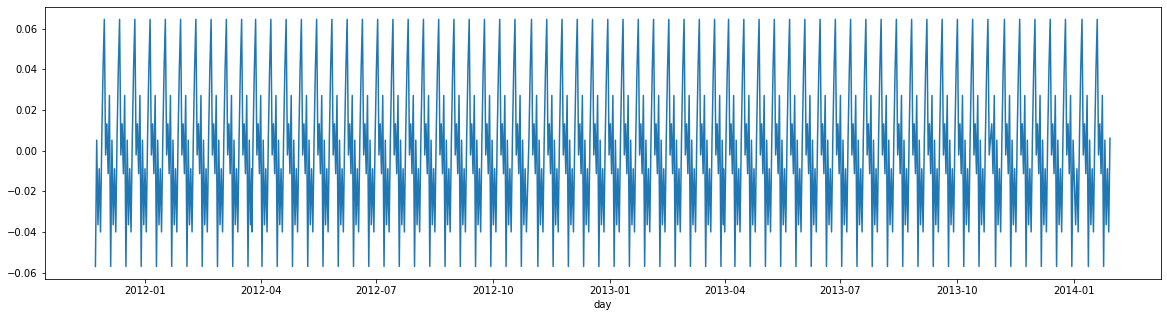

In [72]:
s.seasonal.plot(figsize=(20,5))

<AxesSubplot:xlabel='day'>

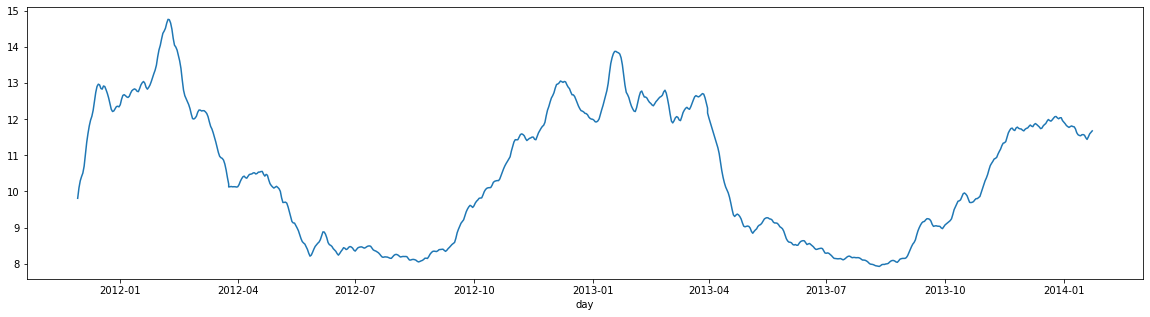

In [73]:
s.trend.plot(figsize=(20,5))

<AxesSubplot:xlabel='day'>

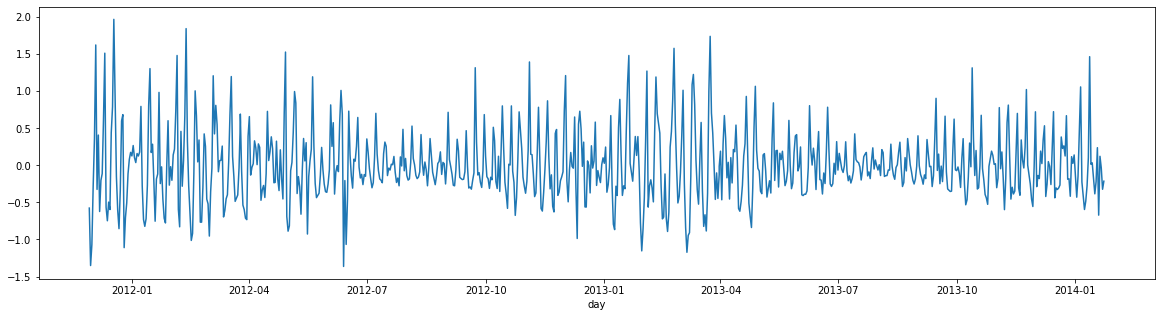

In [74]:
s.resid.plot(figsize=(20,5))

In [75]:
endog = train['avg_energy']
exog = sm.add_constant(train[['weather_cluster','holiday_ind']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,1), seasonal_order=(1,1,0,12), trend='c')
model_fit = mod.fit()
model_fit.summary()

C:\Users\EunJin\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\EunJin\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          avg_energy   No. Observations:                  798
Model:             SARIMAX(7, 1, 1)x(1, 1, [], 12)   Log Likelihood                -649.327
Date:                             Wed, 07 Oct 2020   AIC                           1326.654
Time:                                     12:31:32   BIC                           1391.974
Sample:                                          0   HQIC                          1351.770
                                             - 798                                         
Covariance Type:                               opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.0065      0.017     -0.384      0.701      -0.040       0.027
const           -3.178e-08   2.67e+05  -1.19e-13      1.000   -5.22e+05    5.22e+05
weather_cluster    -0.0076      0.017     -0.458      0.647      -0.040       0.025
holiday_ind        -0.0363      0.088     -0.412      0.680      -0.209       0.136
ar.L1              -0.0028      0.087     -0.033      0.974      -0.172       0.167
ar.L2              -0.1539      0.032     -4.804      0.000      -0.217      -0.091
ar.L3              -0.1440      0.038     -3.749      0.000      -0.219      -0.069
ar.L4              -0.1513      0.038     -3.986      0.000      -0.226      -0.077
ar.L5              -0.1641      0.040     -4.090      0.000      -0.243      -0.085
ar.L6               0.0082      0.036      0.226      0.821      -0.063       0.079
ar.L7               0.3524      0.029     12.274      0.000       0.296       0.409
ma.L1              -0.1839      0.091     -2.014      0.044      -0.363      -0.005
ar.S.L12           -0.4844      0.033    -14.851      0.000      -0.548      -0.420
sigma2              0.3040      0.013     23.951      0.000       0.279       0.329
===================================================================================
Ljung-Box (Q):                      221.67   Jarque-Bera (JB):                45.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.88e+14. Standard errors may be unstable.
"""

### Model Fit

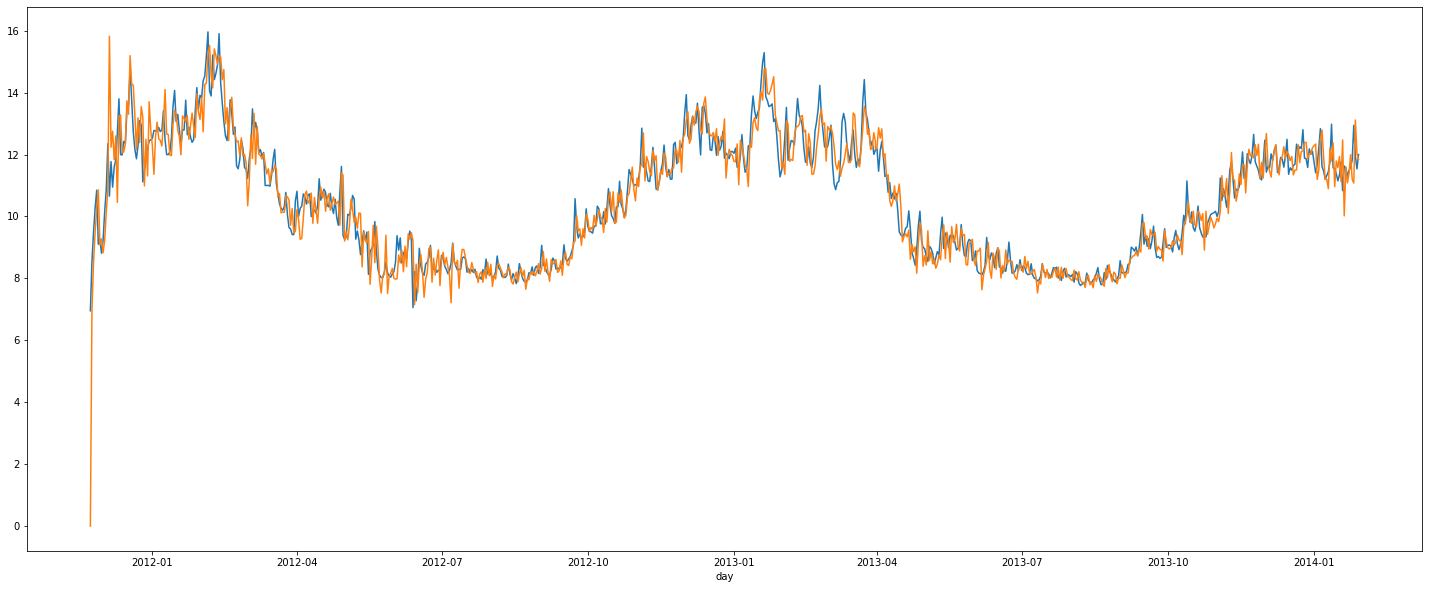

In [76]:
train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

### Prediction

In [77]:
predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=sm.add_constant(test[['weather_cluster','holiday_ind']]))
test['predicted'] = predict.values
test.tail()

C:\Users\EunJin\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\EunJin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,avg_energy,weather_cluster,holiday_ind,predicted
day,,,,
2014-02-23,11.673756,2,0,11.541259
2014-02-24,10.586235,2,0,10.681465
2014-02-25,10.476498,2,0,11.414013
2014-02-26,10.375366,2,0,11.847900
2014-02-27,10.537250,2,0,11.457289


In [78]:
test['residual'] = abs(test['avg_energy']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['avg_energy']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 0.5839424059271745
MAPE: 5.220813860102294


C:\Users\EunJin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


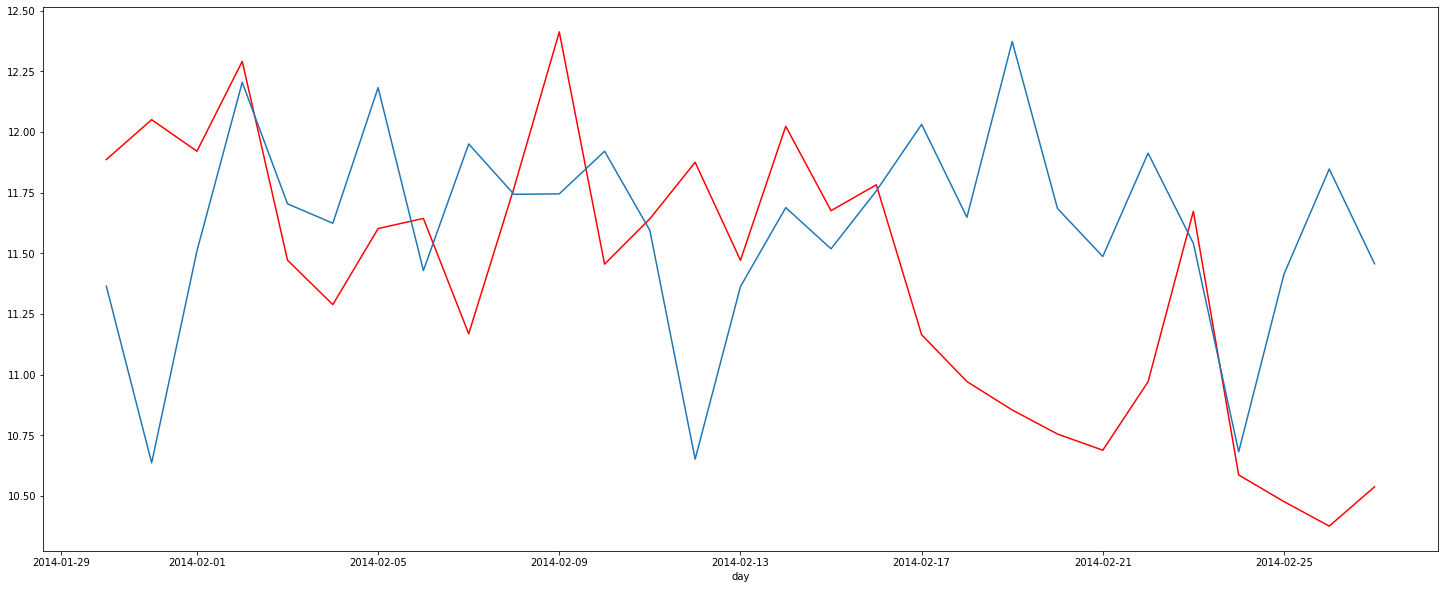

In [79]:
test['avg_energy'].plot(figsize=(25,10), color='red')
test['predicted'].plot()
plt.show()

<AxesSubplot:xlabel='day'>

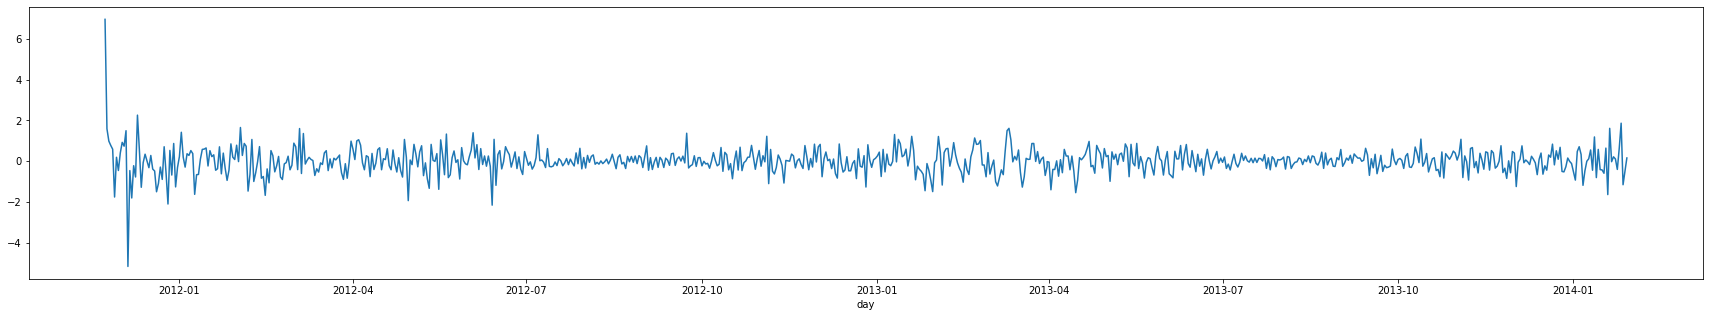

In [80]:
model_fit.resid.plot(figsize=(30,5))

<AxesSubplot:xlabel='day'>

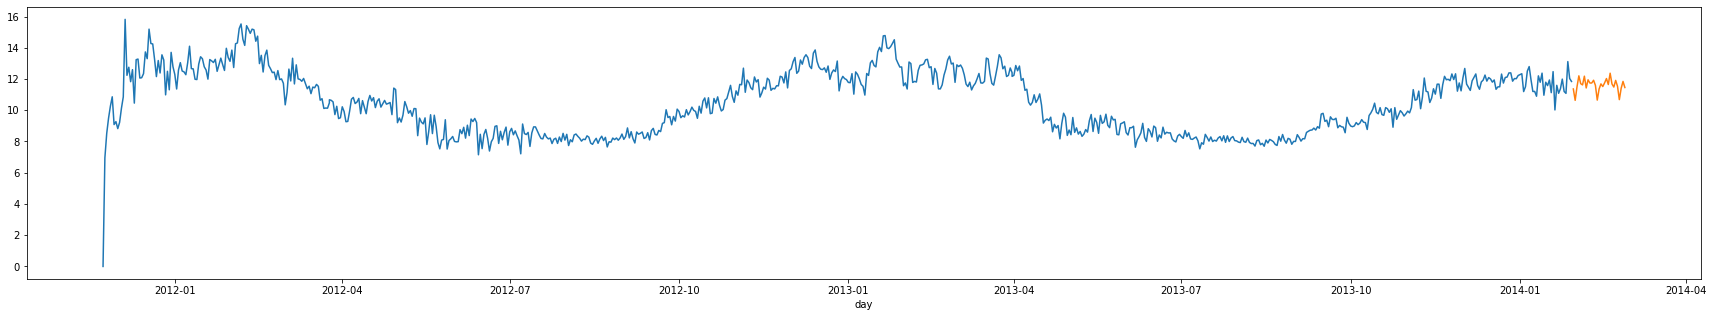

In [81]:
model_fit.fittedvalues.plot(figsize=(30,5))
test.predicted.plot()

In [82]:
test['predicted'].tail()

day
2014-02-23    11.541259
2014-02-24    10.681465
2014-02-25    11.414013
2014-02-26    11.847900
2014-02-27    11.457289
Name: predicted, dtype: float64

# LSTM

Using lags of upto 7 days we are going to convert this into a supervised problem. I have taken the function to create lags from this tutorial by Jason Brownlee. He has also applied the same to convert multivariate data to a supervised dataframe which he has in turn applied LSTM on.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [83]:
np.random.seed(11)
dataframe = weather_energy.loc[:, 'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [84]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [85]:
reframed = series_to_supervised(dataset, 7, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,6.952693,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513
8,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707
9,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910
10,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910,10.862155
11,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910,10.862155,12.351882


In [86]:
reframed['weather_cluster'] = weather_energy.weather_cluster.values[7:]
reframed['holiday_ind']= weather_energy.holiday_ind.values[7:]

In [87]:
reframed = reframed.reindex(['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values

#### Normalization

In [88]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [89]:
# split into train and test sets
train = reframed[:(len(reframed)-30), :]
test = reframed[(len(reframed)-30):len(reframed), :]

In [90]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [91]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(791, 1, 9) (791,) (30, 1, 9) (30,)


### Modeling

Epoch 1/50
11/11 - 0s - loss: 0.6628
Epoch 2/50
11/11 - 0s - loss: 0.5468
Epoch 3/50
11/11 - 0s - loss: 0.4228
Epoch 4/50
11/11 - 0s - loss: 0.2819
Epoch 5/50
11/11 - 0s - loss: 0.1402
Epoch 6/50
11/11 - 0s - loss: 0.1015
Epoch 7/50
11/11 - 0s - loss: 0.1020
Epoch 8/50
11/11 - 0s - loss: 0.0916
Epoch 9/50
11/11 - 0s - loss: 0.0844
Epoch 10/50
11/11 - 0s - loss: 0.0776
Epoch 11/50
11/11 - 0s - loss: 0.0713
Epoch 12/50
11/11 - 0s - loss: 0.0654
Epoch 13/50
11/11 - 0s - loss: 0.0596
Epoch 14/50
11/11 - 0s - loss: 0.0538
Epoch 15/50
11/11 - 0s - loss: 0.0483
Epoch 16/50
11/11 - 0s - loss: 0.0431
Epoch 17/50
11/11 - 0s - loss: 0.0383
Epoch 18/50
11/11 - 0s - loss: 0.0338
Epoch 19/50
11/11 - 0s - loss: 0.0300
Epoch 20/50
11/11 - 0s - loss: 0.0275
Epoch 21/50
11/11 - 0s - loss: 0.0259
Epoch 22/50
11/11 - 0s - loss: 0.0251
Epoch 23/50
11/11 - 0s - loss: 0.0247
Epoch 24/50
11/11 - 0s - loss: 0.0245
Epoch 25/50
11/11 - 0s - loss: 0.0244
Epoch 26/50
11/11 - 0s - loss: 0.0244
Epoch 27/50
11/11 - 0

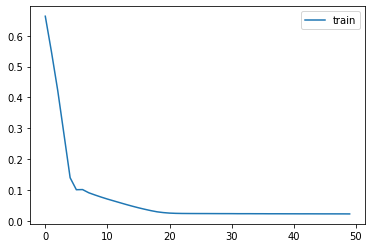

In [92]:
# design network

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

### Prediction

In [93]:
# make a prediction
yhat = model.predict(test_X)

In [94]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [95]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [96]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

### Performance

In [97]:
act = [i[9] for i in inv_y] # last element is the predicted average energy
pred = [i[9] for i in inv_yhat] # last element is the actual average energy

# calculate RMSE
import math
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' %rmse)

Test RMSE: 0.000


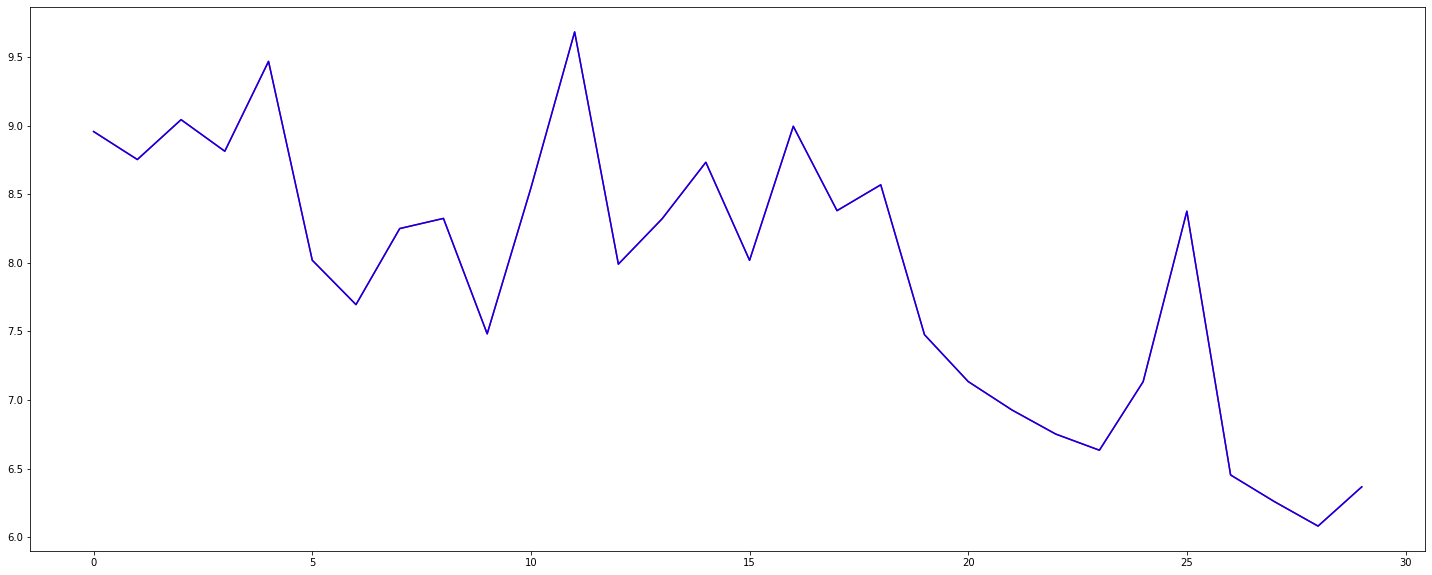

In [98]:
predicted_lstm = pd.DataFrame({'predicted':pred, 'avg_energy':act})
predicted_lstm['avg_energy'].plot(figsize=(25,10), color='red')
predicted_lstm['predicted'].plot(color='blue')
plt.show()